<a href="https://colab.research.google.com/github/asrenninger/city-GPT/blob/main/python/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet duckdb pacmap node2vec adjustText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cudnn-

In [2]:
import pacmap

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import duckdb as db
import networkx as nx

In [ ]:
# initialize DuckDB
con = db.connect(database=':memory:')

# load the required extensions
con.execute("INSTALL httpfs;")
con.execute("INSTALL spatial;")
con.execute("LOAD httpfs;")
con.execute("LOAD spatial;")

# fetch data
query = """
          SELECT
            id,
            confidence,
            CAST(names AS JSON)AS names,
            CAST(categories AS JSON) AS categories,
            CAST(brand AS JSON) AS brand,
            CAST(addresses AS JSON) AS addresses,
            CAST(websites AS JSON) AS websites,
            ST_AsText(ST_GeomFromWKB(geometry)) AS geometry
          FROM
            read_parquet('s3://overturemaps-us-west-2/release/2024-05-16-beta.0/theme=places/type=*/*', hive_partitioning=1)
          WHERE
            bbox.xmin > -11.02
            AND bbox.xmax < 1.77
            AND bbox.ymin > 49.95
            AND bbox.ymax < 59.74
        """

# execute the query and load data
df = con.execute(query).fetchdf()
df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,id,confidence,names,categories,brand,addresses,websites,geometry
0,08f187293142a411035565e6a3b635d9,0.545360,"{""primary"":""Norrard Rocks"",""common"":null,""rule...","{""main"":""landmark_and_historical_building"",""al...",None,"[{""freeform"":null,""locality"":null,""postcode"":n...",None,POINT (-6.37 49.9533)
1,08f1872931008b0c03541a29324e67b5,0.426304,"{""primary"":""Glenhope & Glenhope High Holiday C...","{""main"":""bed_and_breakfast"",""alternate"":[""cott...",None,"[{""freeform"":""Bryher"",""locality"":""Hugh Town"",""...","[""http://www.visitbryher.co.uk""]",POINT (-6.3571668 49.9510416)
2,08f187293100c4c8032420dd4be9096a,0.667112,"{""primary"":""Bryher, Isles of Scilly"",""common"":...","{""main"":""landmark_and_historical_building"",""al...",None,"[{""freeform"":null,""locality"":null,""postcode"":n...",None,POINT (-6.3575439 49.9513932)
3,08f187293100e813032db62be551544c,0.964027,"{""primary"":""Hell Bay Hotel"",""common"":null,""rul...","{""main"":""hotel"",""alternate"":[""restaurant"",""acc...",None,"[{""freeform"":""Bryher, Isles of Scilly"",""locali...","[""https://linktr.ee/hellbayhotel""]",POINT (-6.3578261 49.9515001)
4,08f187293102cc6803cd90fde71b6134,0.895433,"{""primary"":""The Crab Shack"",""common"":null,""rul...","{""main"":""seafood_restaurant"",""alternate"":[""foo...",None,"[{""freeform"":""Bryher"",""locality"":""Isles Of Sci...","[""https://www.hellbay.co.uk/dining-with-us/cra...",POINT (-6.3562132 49.9524559)


In [ ]:
from shapely import wkt
gs = gpd.GeoSeries(df['geometry'].apply(wkt.loads))

In [ ]:
gf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")

In [ ]:
gf.to_crs("EPSG:4326", inplace=True)

df['lon'] = gf.centroid.x
df['lat'] = gf.centroid.y

gf.to_crs("EPSG:27700", inplace=True)

df['x'] = gf.centroid.x
df['y'] = gf.centroid.y

<ipython-input-103-bc7cfd1129b8>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = gf.centroid.x
<ipython-input-103-bc7cfd1129b8>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = gf.centroid.y


In [4]:
import json
import ast
import re

In [ ]:
# get the primary name...
def get_name(json_str):
    try:
        data = json.loads(json_str)
        return data['primary'] if data['primary'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

# ...and the first category...
def get_category(json_str):
    try:
        data = json.loads(json_str)
        return data['main'] if data['main'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

# ...and another option.
def get_alternate(json_str):
    try:
        data = json.loads(json_str)
        return data['alternate'][0] if data['alternate'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

# get the brand if there is one.
def get_brand(json_str):
    if not json_str:
        return None
    try:
        # Parse the JSON string
        data = json.loads(json_str)
        # Extract the primary name from the names object
        return data.get('names', {}).get('primary', None)
    except (json.JSONDecodeError, TypeError):
        return None


# get the website of there is one.
def get_website(list_str):
    if not list_str:
        return None
    try:
        data = ast.literal_eval(list_str)
        return data[0] if data else None
    except (ValueError, SyntaxError, IndexError, TypeError):
        return None

# get the country from the address to filter on that.
def get_country(json_str):
    if not json_str:
        return None
    try:
        data = json.loads(json_str)
        return data[0].get('country', None)
    except (json.JSONDecodeError, IndexError, TypeError):
        return None

In [ ]:
df['name'] = df['names'].apply(get_name)
df['category'] = df['categories'].apply(get_category)
df['alternate'] = df['categories'].apply(get_alternate)
df['country'] = df['addresses'].apply(get_country)
df['website'] = df['websites'].apply(get_website)
df['brand'] = df['brand'].apply(get_brand)

In [ ]:
df = df[
    (df['country']=='GB') & (df['category'].notnull()) & (df['name'].notnull())
    ]
df = df.drop(['addresses', 'websites', 'country'], axis=1)
df = df[['id', 'confidence', 'name', 'category', 'alternate', 'brand', 'website', 'lon', 'lat', 'x', 'y', 'geometry']]
df.head()

,id,confidence,name,category,alternate,brand,website,lon,lat,x,y,geometry
0,08f187293142a411035565e6a3b635d9,0.545360,Norrard Rocks,landmark_and_historical_building,island,None,None,-6.370000,49.953300,86650.738526,15059.727426,POINT (-6.37 49.9533)
1,08f1872931008b0c03541a29324e67b5,0.426304,"Glenhope & Glenhope High Holiday Cottages, Bryher",bed_and_breakfast,cottage,None,http://www.visitbryher.co.uk,-6.357167,49.951042,87556.273753,14754.993784,POINT (-6.3571668 49.9510416)
2,08f187293100c4c8032420dd4be9096a,0.667112,"Bryher, Isles of Scilly",landmark_and_historical_building,island,None,None,-6.357544,49.951393,87531.512714,14795.644919,POINT (-6.3575439 49.9513932)
3,08f187293100e813032db62be551544c,0.964027,Hell Bay Hotel,hotel,restaurant,None,https://linktr.ee/hellbayhotel,-6.357826,49.951500,87511.970445,14808.705331,POINT (-6.3578261 49.9515001)
4,08f187293102cc6803cd90fde71b6134,0.895433,The Crab Shack,seafood_restaurant,food,None,https://www.hellbay.co.uk/dining-with-us/crab-...,-6.356213,49.952456,87633.818654,14908.178983,POINT (-6.3562132 49.9524559)


In [ ]:
df[df['website'].notnull()].shape[0] / df.shape[0]

0.8042160954401911

In [ ]:
counts = df.groupby('category', as_index=False)[['name']].count().sort_values('name', ascending= False)
bottom = counts[(counts['name'] < 20) & counts['category'].str.contains("_restaurant")]

In [ ]:
sub = df.copy()

In [ ]:
sub['category'] = sub['category'].apply(lambda x: 'other_restaurant' if x in bottom.category.tolist() else x)

In [ ]:
cut = counts[counts['name'] < 20]

In [ ]:
def recode(cat_str, val_cat):
  """
  make all strings that contain _museum into just 'museum'...
  ...and all strings that contain _club into just 'club.

  else return the original string
  """
  if cat_str is None:
    return 'other'

  if cat_str not in val_cat:
    return cat_str

  if 'museum' in cat_str:
    return 'museum'
  elif '_grocery' in cat_str:
    return 'specialty_grocery_store'
  elif '_bar' in cat_str:
    return 'bar'
  elif '_clinic' in cat_str:
    return 'clinic'
  elif 'b2b' in cat_str:
    return 'b2b'
  elif 'other_stadium' in cat_str:
    return 'stadium'
  else:
    return cat_str

sub['category'] = sub['category'].apply(lambda x: recode(x, cut.category.tolist()))

In [ ]:
counts = sub.groupby('category', as_index=False)[['name']].count().sort_values('name', ascending= False)
bottom = counts[(counts['name'] < 10)]

In [ ]:
sub = sub[~sub['category'].isin(bottom.category.tolist())]

In [ ]:
def clean_name(name):
    if not isinstance(name, str):
        return name

    # step 1: Remove parentheticals
    name = re.sub(r'\(.*?\)', '', name)
    # step 2: Replace all caps ATM with ATM
    name = re.sub(r'\bATM\b', 'ATM', name)
    # step 3: Replace "Iceland" with "Iceland Foods"
    if name.strip() == "Iceland":
        name = "Iceland Foods"
    # step 4: Replace "Boots" with "Boots Pharmacy"
    if name.strip() == "Boots":
        name = "Boots Pharmacy"
    # step 5: Replace anything with "Boots Opticians" with "Boots Opticians"
    if "Boots Opticians" in name:
        name = "Boots Opticians"
    # step 6: Replace instances of m and s or m&s with M&S (not case sensitive)
    name = re.sub(r'\bm[&\s]?s\b', 'M&S', name, flags=re.IGNORECASE)
    # step 7: Remove stray GB or UK or UK & Ireland with leading spaces
    name = re.sub(r'\s+(GB|UK|UK & Ireland)', '', name)
    # step 8: Replace anything with "Royal Mail" with "Royal Mail"
    if "Royal Mail" in name:
        name = "Royal Mail"
    # step 9: Replace anything with "Domino's Pizza" with "Domino's Pizza"
    if "Domino's Pizza" in name:
        name = "Domino's Pizza"
    # step 10: Replace anything with "Pizza Hut" with "Pizza Hut"
    if "Pizza Hut" in name:
        name = "Pizza Hut"
    # step 11: Replace "Company" at the end with "Co"
    name = re.sub(r'\bCompany\b$', 'Co', name)
    # step 12: Replace anything with "Pret a Manger" with "Pret a Manger" (case insensitive)
    if re.search(r'Pret a Manger', name, re.IGNORECASE):
        name = re.sub(r'Pret a Manger.*', 'Pret a Manger', name, flags=re.IGNORECASE)
    # step 13: Strip anything after "M&S" except "Cafe"
    if name.startswith("M&S"):
        if "Cafe" in name:
            name = "M&S Cafe"
        else:
            name = "M&S"
    # step 14: Replace any entry containing "Argos" with "Argos"
    if "Argos" in name:
        name = "Argos"
    # step 15: Strip out any special characters at the end of the name
    name = re.sub(r'[^\w\s]$', '', name)

    # remove extra spaces
    name = name.strip()
    return name

In [ ]:
sub['name'] = sub['name'].apply(clean_name)

In [5]:
pub_names = [
    "Red Lion",
    "The Crown",
    "Royal Oak",
    "White Hart",
    "The Swan",
    "The Plough",
    "The Bell",
    "Rose & Crown",
    "Queens Head",
    "Railway Tavern",
    "The Ship",
    "Kings Arms",
    "White Horse",
    "Kings Head",
    "Chequers",
    "Rising Sun",
    "The George",
    "Fox & Hounds",
    "Prince Of Wales",
    "Black Horse",
    "The Fox",
    "Cross Keys",
    "The Star",
    "Three Horseshoes",
    "The Greyhound",
    "Coach & Horses",
    "The Victoria",
    "George & Dragon",
    "Masons Arms",
    "Hare & Hounds",
    "White Lion",
    "The Sun",
    "White Swan",
    "Nags Head",
    "Carpenters Arms",
    "Duke Of York",
    "Cricketers",
    "Windmill",
    "Black Lion",
    "Travellers Rest",
    "Station Hotel",
    "Golden Lion",
    "The George",
    "Bird In Hand",
    "Black Bull",
    "Horse & Groom",
    "Butchers Arms",
    "Bulls Head",
    "The Beehive",
    "The Anchor",
    "The Castle",
    "Red Dragon",
    "The Eagle",
    "The Green Man",
    "The Royal George",
    "The King's Head",
    "The Fox & Hound",
    "The Rose",
    "The Jolly Farmer",
    "The Old Mill",
    "The Ship Inn",
    "The Admiral",
    "The Old Bell",
    "The Queen's Arms",
    "The Crown & Anchor",
    "The White Lion",
    "The Black Swan",
    "The Cherry Tree",
    "The Blue Boar",
    "The Sun Inn",
    "The Bear",
    "The White Bear",
    "The Three Tuns",
    "The Greyhound Inn",
    "The Green Dragon",
    "The Bull",
    "The Lamb",
    "The Dog & Duck",
    "The Kings Head",
    "The Saracens Head",
    "The New Inn",
    "The Farmers Arms",
    "The Seven Stars",
    "The Bluebell",
    "The Red Hart",
    "The Old Crown",
    "The Wellington",
    "The Griffin",
    "The Unicorn",
    "The Fox Inn",
    "The Rising Sun Inn",
    "The Kings Arms Hotel",
    "The Old Ship",
    "The Duke Of Wellington",
    "The Black Boy",
    "The George & Dragon Inn",
    "The Bull & Bush",
    "The Golden Fleece",
    "The Peasant",
    "The Cricketers Arms"
]

In [ ]:
sub['name'] = sub.apply(lambda row: "Classic Pub" if row['name'] in pub_names and row['category'] in ['pub', 'bar'] else row['name'], axis=1)
mask = sub['name'].map(sub['name'].value_counts()) > 9
sub['label'] = np.where(mask, sub['name'], sub['category'])

In [ ]:
sub['label'] = sub['label'].str.replace("_", " ")

In [ ]:
sub = sub.dropna(subset=['label'])

In [ ]:
sub.shape

(2054931, 13)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sub.drop(['geometry'], axis=1).to_csv("drive/MyDrive/overture/overture_cleaned.csv")

In [7]:
pois = pd.read_csv("drive/MyDrive/overture/overture_cleaned.csv")

In [8]:
pois.head()

,id,confidence,name,category,alternate,brand,website,lon,lat,x,y,label
0,08f187293142a411035565e6a3b635d9,0.545360,Norrard Rocks,landmark_and_historical_building,island,NaN,NaN,-6.370000,49.953300,86650.738526,15059.727426,landmark and historical building
1,08f1872931008b0c03541a29324e67b5,0.426304,"Glenhope & Glenhope High Holiday Cottages, Bryher",bed_and_breakfast,cottage,NaN,http://www.visitbryher.co.uk,-6.357167,49.951042,87556.273753,14754.993784,bed and breakfast
2,08f187293100c4c8032420dd4be9096a,0.667112,"Bryher, Isles of Scilly",landmark_and_historical_building,island,NaN,NaN,-6.357544,49.951393,87531.512714,14795.644919,landmark and historical building
3,08f187293100e813032db62be551544c,0.964027,Hell Bay Hotel,hotel,restaurant,NaN,https://linktr.ee/hellbayhotel,-6.357826,49.951500,87511.970445,14808.705331,hotel
4,08f187293102cc6803cd90fde71b6134,0.895433,The Crab Shack,seafood_restaurant,food,NaN,https://www.hellbay.co.uk/dining-with-us/crab-...,-6.356213,49.952456,87633.818654,14908.178983,seafood restaurant


In [9]:
from scipy.spatial import cKDTree
trees = cKDTree(pois[['x', 'y']].values)
pairs = trees.query_pairs(r=500, output_type='ndarray')

In [ ]:
%%time
from collections import Counter
counting = Counter()

names = pois['label'].to_dict()

for i, j in pairs:
    pair = tuple(sorted((names[i], names[j])))
    counting[pair] += 1

In [ ]:
import random
sampled_keys = random.sample(list(counting.keys()), 250000)
sampled_dict = {k: counting[k] for k in sampled_keys}

In [ ]:
G = nx.Graph()
for (u, v), w in sampled_dict.items():
    G.add_edge(u, v, weight=w)

In [ ]:
from node2vec import Node2Vec

In [14]:
n2v = Node2Vec(G, dimensions=64, walk_length=10, num_walks=5, workers=8)

Computing transition probabilities:   0%|          | 0/5129 [00:00<?, ?it/s]

In [15]:
model = n2v.fit(window=10, min_count=1, batch_words=4)
embed = model.wv

In [ ]:
pcmp = pacmap.PaCMAP(n_components=3, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0).fit_transform(embed.vectors, init='pca')

In [17]:
top_n = pois['name'].value_counts()
top_n = top_n[top_n > 20]

In [18]:
labels = top_n.iloc[:50]
labels = labels.index.tolist()

In [19]:
categories = pois.groupby(["category", "label"], as_index=False).size().sort_values("size", ascending=False).groupby("label", as_index=False).first()
categories = categories[["category", "label"]].set_index("label")

In [20]:
def recode(cat_str):
  """
  come up with a bunch of broad categories show in our plots
  """
  if cat_str is None:
        return 'other'

  import re
  if re.search('distributor|wholesale|beverage', cat_str, re.IGNORECASE):
    return 'wholesale'
  elif re.search('\bbar\b|\bpub\b|inn|cafe|brewery|coffee|bakery', cat_str, re.IGNORECASE):
    return 'drink'
  elif re.search('restaurant|food|stand|cart|sandwich', cat_str, re.IGNORECASE):
    return 'food'
  elif re.search('hotel|breakfast', cat_str, re.IGNORECASE):
    return 'hotel'
  elif re.search('(?<!grocery_)store|shop|clothing|rental', cat_str, re.IGNORECASE):
    return 'shop'
  elif re.search('club|gym|fitness', cat_str, re.IGNORECASE):
    return 'leisure'
  elif re.search('museum|stadium', cat_str, re.IGNORECASE):
    return 'events'
  elif re.search('market(?!ing)|grocer', cat_str, re.IGNORECASE):
    return 'grocery'
  else:
    return 'other'

categories['broad'] = categories['category'].apply(recode)
categories.head()

,category,broad
label,,
& Other Stories,women's_clothing_store,shop
3 Store,mobile_phone_store,shop
3d printing service,3d_printing_service,other
888 Vapour,e_cigarette_store,shop
A Cut Above,beauty_salon,other


In [21]:
import colorcet as cc

In [22]:
c_ = categories.broad.unique()

colormaps = {}

for seed in range(10):
  np.random.seed(seed)
  _c = np.random.permutation(c_)

  colors = {k: cc.glasbey_dark[i] for i, k in enumerate(_c)}
  colors['other'] = '#7a7a7a'

  crosswalk = categories.to_dict()
  crosswalk = crosswalk.get('broad')

  crosswalk = {i: [v, colors.get(v)] for i, v in crosswalk.items()}

  colormaps[seed] = crosswalk

In [23]:
crosswalk = colormaps[3]

In [24]:
sizes = top_n.to_dict()
sizes = [10 if a is None else (a / 10) + 10 for a in [sizes.get(b) for b in embed.index_to_key]]

colors = [crosswalk.get(b)[1] for b in embed.index_to_key]

In [25]:
list_of_lists = categories[categories['broad'].str.contains('drink|food|grocer|shop') & ~categories.index.isin(pub_names)].reset_index().merge(top_n.reset_index().rename(columns={'name': 'label'}), on='label', how='left').dropna().groupby('broad').apply(lambda x: x.sort_values('count', ascending=False).head(10)).reset_index(drop=True).groupby('broad')['label'].apply(list).tolist()

In [26]:
from adjustText import adjust_text

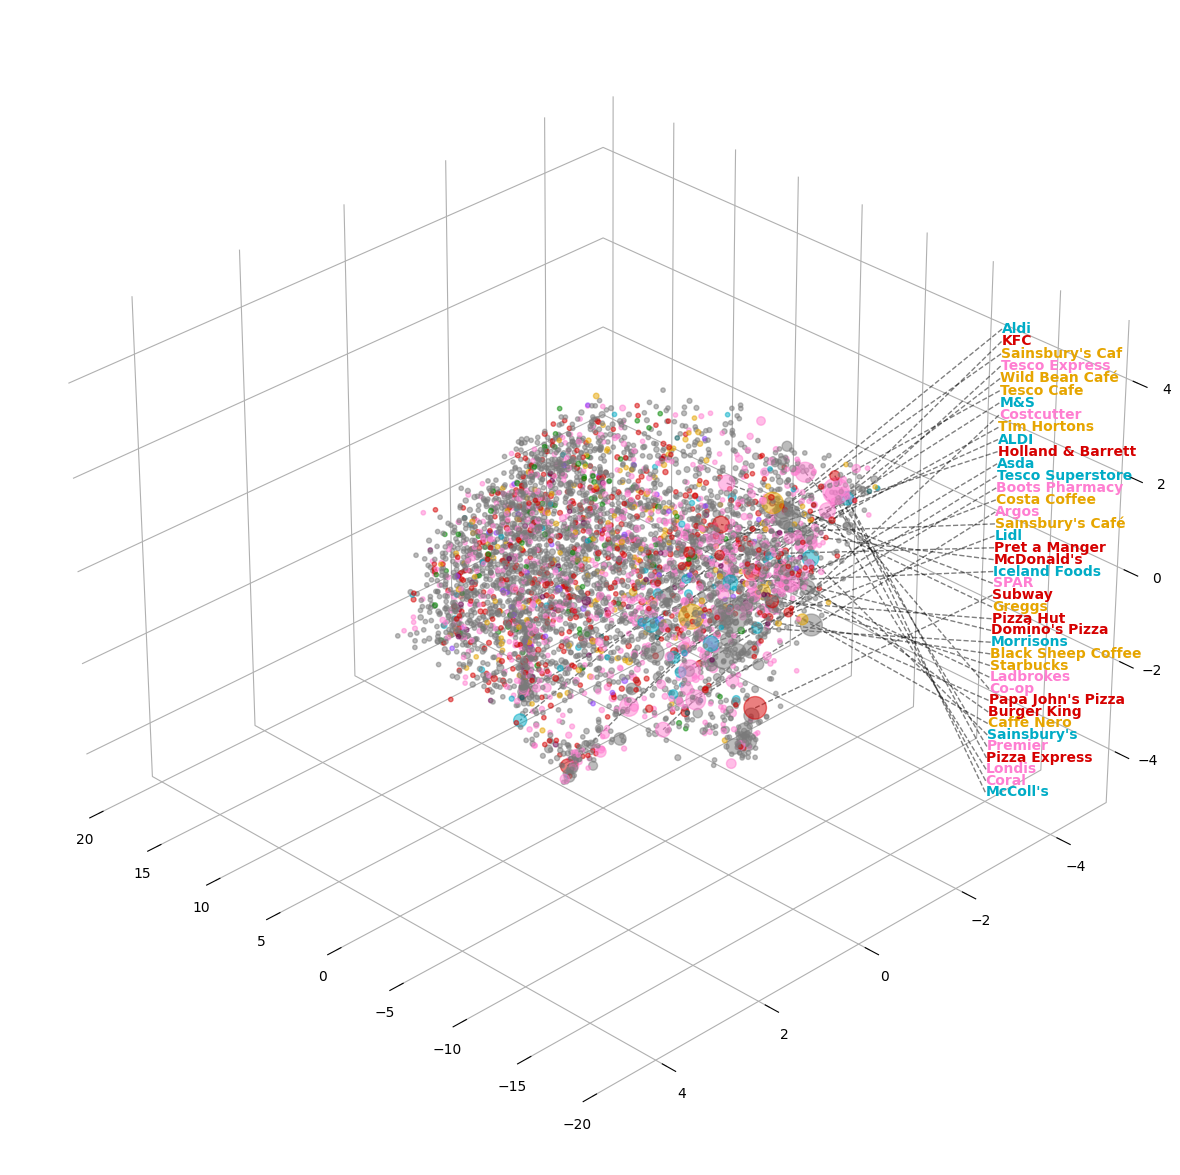

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# create the figure and 3D axis objects
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot with smaller white points
ax.scatter(pcmp[:, 0], pcmp[:, 1], pcmp[:, 2], color=colors, s=sizes, alpha=0.5)

# customizing the axes (removing frame for clarity)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Customizing the axes
for side in ['left', 'right', 'top', 'bottom']:
  ax.spines[side].set_visible(False)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
ax.set_xlim(-20, 20)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.xaxis.line.set_color((0.5, 0.5, 0.5, 0))
ax.yaxis.line.set_color((0.5, 0.5, 0.5, 0))
ax.zaxis.line.set_color((0.5, 0.5, 0.5, 0))

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')

# sort labels based on their y-values in pcmp
label_y_values = {brand: pcmp[i, 1] for i, brand in enumerate(embed.index_to_key) if brand in sum(list_of_lists, [])}
sorted_labels = sorted(label_y_values, key=label_y_values.get)

# calculate regular z intervals, now based on sorted labels
z_positions = np.linspace(ax.get_zlim()[0], ax.get_zlim()[1], len(sorted_labels))

texts = []
for i, brand in enumerate(sorted_labels):
    col = crosswalk.get(brand)
    brand_clean = re.sub(r"\s*\([^)]*\)", "", brand)
    brand_clean = re.sub(r" opticians and audiologists|centre", "", brand_clean)
    pcmp_index = embed.index_to_key.index(brand)  # Find the original index of the brand in pcmp
    # align text on the left edge, using z-positions sorted by pcmp's y-value
    texts.append(ax.text(-15, -4, z_positions[i], brand_clean, color=col[1], weight='bold', ha='left', va='center'))
    # draw line to the original point
    ax.plot([-15, pcmp[pcmp_index, 0]], [-4, pcmp[pcmp_index, 1]], [z_positions[i], pcmp[pcmp_index, 2]], color='k', linestyle='--', linewidth=1, alpha=0.5)

# adjust the view angle
ax.view_init(elev=30, azim=135)

plt.show()

In [41]:
distances, indices = trees.query(pois[['x', 'y']].values, k=11, distance_upper_bound=500)

In [45]:
d_noninf = distances[[i for i, dist in enumerate(distances) if not np.isinf(dist).any()]]
i_noninf = indices[[i for i, dist in enumerate(distances) if not np.isinf(dist).any()]]

In [56]:
# get out of pandas so this doesn't take forever
poi_labs = pois['label'].values

In [63]:
poi_data = np.array([poi_labs[i][::-1] for i in i_noninf])

In [64]:
sets = [set(i) for i in poi_data]
tkns = sets[0].union(*sets[1:])

In [65]:
chars = sorted(tkns)
vocab = len(chars)

In [71]:
# create a mapping from characters to integers
stoi = { tkn:i for i,tkn in enumerate(tkns) }
itos = { i:tkn for i,tkn in enumerate(tkns) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: [itos[i] for i in l] # decoder: take a list of integers, output a string

test = [
    'Foot Locker',
    'Burger King',
    'Classic Pub',
    'Pret a Manger',
    'John Lewis'
    ]

print(encode(test))
print(decode(encode(test)))

test = [
    'hotel',
    'bed and breakfast',
    'bakery',
    'cafe',
    'landmark and historical building'
    ]

print(encode(test))
print(decode(encode(test)))

[2486, 3038, 297, 4106, 4247]
['Foot Locker', 'Burger King', 'Classic Pub', 'Pret a Manger', 'John Lewis']
[1136, 3465, 1225, 551, 2454]
['hotel', 'bed and breakfast', 'bakery', 'cafe', 'landmark and historical building']


In [72]:
-np.log((1/vocab))

8.542665987389269

In [73]:
import torch

In [74]:
encoded = [encode(i) for i in poi_data]

n = int(0.8*len(encoded))
train_data = torch.tensor(encoded[:n])
valid_data = torch.tensor(encoded[n:])

In [106]:
# hyperparameters
batch_size = 16
block_size = 10
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.1

In [118]:
import torch.nn as nn
torch.manual_seed(1337)

# data loading
def get_batch(split):
    data = train_data if split == 'train' else valid_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data[i, :block_size] for i in ix])
    y = torch.stack([data[i, block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# def get_batch(split):
#     # generate a small batch of data of inputs x and targets y
#     data = train_data if split == 'train' else valid_data
#     ix = torch.randint(len(data) - block_size, (batch_size,))
#     x = torch.stack([data[i:i+block_size] for i in ix])
#     y = torch.stack([data[i+1:i+block_size+1] for i in ix])
#     x, y = x.to(device), y.to(device)
#     return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

from torch.nn import functional as F
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# modified model for fixed context prediction
class BrandPredictionModel(nn.Module):
    """ brand prediction with embedding, transformer and linear layer """

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab)

        if targets is None:
            loss = None
        else:
            logits = logits[:, -1, :] # we only care about the prediction of the next brand
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def predict(self, idx):
        logits, _ = self(idx)
        return torch.argmax(logits, dim=-1)

In [119]:
model = BrandPredictionModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.861449 M parameters


In [120]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 8.7143, val loss 8.7239
step 100: train loss 6.7521, val loss 6.7483
step 200: train loss 6.6145, val loss 6.5106
step 300: train loss 6.5041, val loss 6.5478
step 400: train loss 6.4761, val loss 6.5598
step 500: train loss 6.4288, val loss 6.4559
step 600: train loss 6.4752, val loss 6.4458
step 700: train loss 6.4881, val loss 6.4701
step 800: train loss 6.4376, val loss 6.4155
step 900: train loss 6.4188, val loss 6.3753
step 1000: train loss 6.4456, val loss 6.4527
step 1100: train loss 6.3888, val loss 6.3577
step 1200: train loss 6.4058, val loss 6.4067
step 1300: train loss 6.3620, val loss 6.3863
step 1400: train loss 6.3882, val loss 6.3907
step 1500: train loss 6.4170, val loss 6.3153
step 1600: train loss 6.3202, val loss 6.4325
step 1700: train loss 6.3934, val loss 6.3383
step 1800: train loss 6.3766, val loss 6.2775
step 1900: train loss 6.3335, val loss 6.3337
step 2000: train loss 6.3213, val loss 6.3366
step 2100: train loss 6.3383, val loss 6.3784


In [124]:
# mcdonalds = [i for i in poi_data if "McDonald's" in i[10]]
# context = torch.tensor(encode(mcdonalds[0][:9]), dtype=torch.long, device=device)
# predicted_brand = m.predict(context)
# print(predicted_brand.item())

In [ ]:
#### to do
# 1. [ ] reintroduce predicting at all possible subblocks within each block
# 2. [ ] use the embeddings
# 3. [x] reintroduce positional encoding and see if that helps (it does not)
# 4. [ ] log more data along the way
# 5. [ ] create a generation function to produce site recommendations